In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [3]:
# Load CIFAR-10 dataset
(x_train_10, y_train_10), (x_test_10, y_test_10) = cifar10.load_data()
x_train_10, x_test_10 = x_train_10 / 255.0, x_test_10 / 255.0


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 53s 0us/step


In [4]:
# Convert class vectors to binary class matrices (one-hot encoding)
y_train_10 = to_categorical(y_train_10, 10)
y_test_10 = to_categorical(y_test_10, 10)

Build and Train a Simple Model

In [5]:
def build_model(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Build and compile model for CIFAR-10
model_10 = build_model(10)
model_10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on CIFAR-10
model_10.fit(x_train_10, y_train_10, epochs=10, batch_size=64, validation_data=(x_test_10, y_test_10))


D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.3534 - loss: 1.7772 - val_accuracy: 0.5615 - val_loss: 1.2465
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5689 - loss: 1.2200 - val_accuracy: 0.5980 - val_loss: 1.1495
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6233 - loss: 1.0787 - val_accuracy: 0.6373 - val_loss: 1.0546
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6584 - loss: 0.9829 - val_accuracy: 0.6544 - val_loss: 0.9969
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6842 - loss: 0.9143 - val_accuracy: 0.6724 - val_loss: 0.9581
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7001 - loss: 0.8681 - val_accuracy: 0.6813 - val_loss: 0.9433
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7178 - loss: 0.8164 - val_accuracy: 0.6852 - val_loss: 0.9331
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7340 - loss: 0.7683 - val_accuracy: 0

 FGSM Attack Implementation

In [8]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the sign of the gradients
    sign_data_grad = tf.sign(data_grad)
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    return perturbed_image

# Function to create adversarial examples
def create_adversarial_pattern(model, image, label):
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    # Get the gradients of the loss w.r.t to the input image
    gradient = tape.gradient(loss, image)
    return gradient

# Create adversarial examples for CIFAR-10 test set
epsilon = 0.1  # Amount of perturbation
adversarial_examples = []
for i in range(len(x_test_10)):
    img = x_test_10[i:i+1]
    label = y_test_10[i:i+1]
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    label_tensor = tf.convert_to_tensor(label, dtype=tf.float32)
    gradient = create_adversarial_pattern(model_10, img_tensor, label_tensor)
    adversarial_img = fgsm_attack(img_tensor, epsilon, gradient)
    adversarial_examples.append(adversarial_img.numpy())
adversarial_examples = np.array(adversarial_examples).reshape(-1, 32, 32, 3)


 Evaluate the Model on Adversarial Examples

In [9]:
# Evaluate the model on adversarial examples
loss, accuracy = model_10.evaluate(adversarial_examples, y_test_10, verbose=0)
print(f"Accuracy on adversarial examples: {accuracy * 100:.2f}%")


Accuracy on adversarial examples: 0.06%


Visualize Adversarial Examples

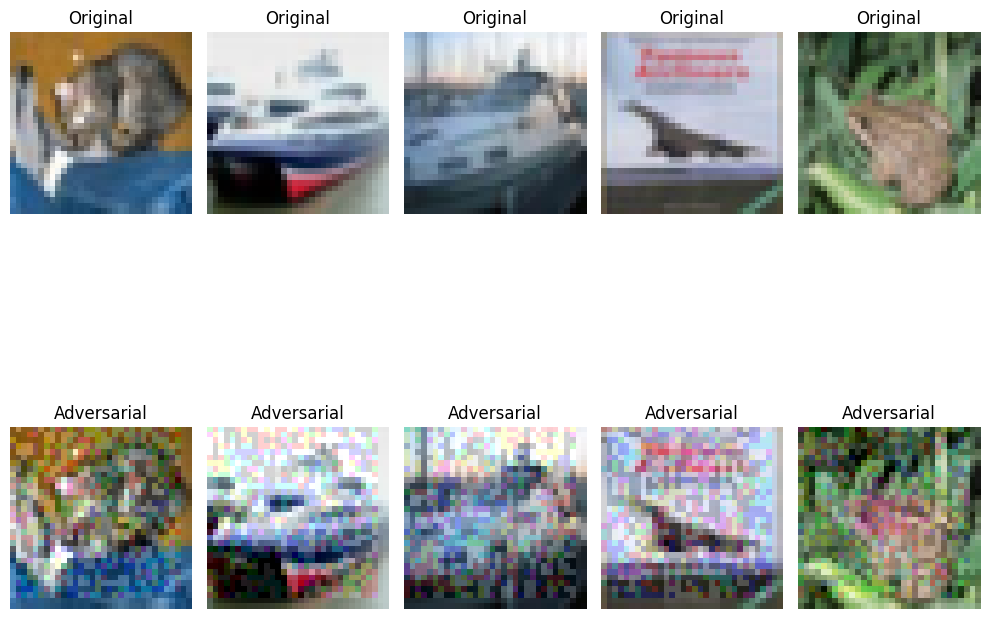

In [10]:
# Visualize original and adversarial examples
num_examples = 5
plt.figure(figsize=(10, 10))
for i in range(num_examples):
    plt.subplot(2, num_examples, i + 1)
    plt.imshow(x_test_10[i])
    plt.title("Original")
    plt.axis('off')
    plt.subplot(2, num_examples, i + 1 + num_examples)
    plt.imshow(adversarial_examples[i])
    plt.title("Adversarial")
    plt.axis('off')
plt.tight_layout()
plt.show()
